In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/osteoarthritis-prediction/Valid/Valid/Osteoarthritis/9643944R.png
/kaggle/input/osteoarthritis-prediction/Valid/Valid/Normal/9040944L.png
/kaggle/input/osteoarthritis-prediction/test/test/Osteoarthritis/9267247_1.png
/kaggle/input/osteoarthritis-prediction/test/test/Normal/NormalG0 (364).png
/kaggle/input/osteoarthritis-prediction/train/train/Osteoarthritis/DoubtfulG1 (76).png
/kaggle/input/osteoarthritis-prediction/train/train/Normal/9133694L.png


In [1]:
!mkdir tmp/
!cd tmp/
!mkdir Normal/ Osteoarthritis/
!cp -r /kaggle/input/osteoarthritis-prediction/train/train/Normal/*.png Normal/
!cp -r /kaggle/input/osteoarthritis-prediction/train/train/Osteoarthritis/*.png Osteoarthritis/
!cp -r /kaggle/input/osteoarthritis-prediction/test/test/Normal/*.png Normal/
!cp -r /kaggle/input/osteoarthritis-prediction/test/test/Osteoarthritis/*.png Osteoarthritis/
!cp -r /kaggle/input/osteoarthritis-prediction/Valid/Valid/Normal/*.png Normal/
!cp -r /kaggle/input/osteoarthritis-prediction/Valid/Valid/Osteoarthritis/*.png Osteoarthritis/


import torch
import os, sys, json, cv2, random, torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import seaborn as sns
from PIL import Image
from numpy import interp
import warnings
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import auc, f1_score, roc_curve, classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from itertools import cycle

In [5]:
!cp -r Normal/ tmp/
!cp -r Osteoarthritis/ tmp/

Osteoarthritis         : 100%|████████████████████████████████████████| 2026/2026 [00:02<00:00, 1008.13file/s]


2 kind of images were found in the dataset
3615 images were found in the dataset.
2892 for training, 723 for validation
average image height=  191   average image width=  277  aspect ratio h/w=  0.6895306859205776


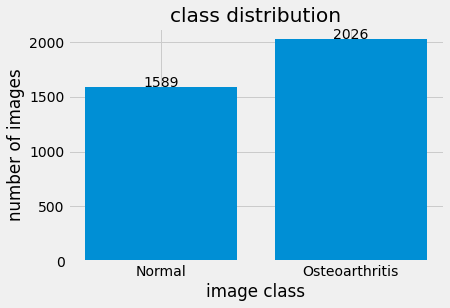

[valid epoch 4] loss: 0.494, acc: 0.783: 100%|██████████| 23/23 [00:02<00:00,  9.42it/s]


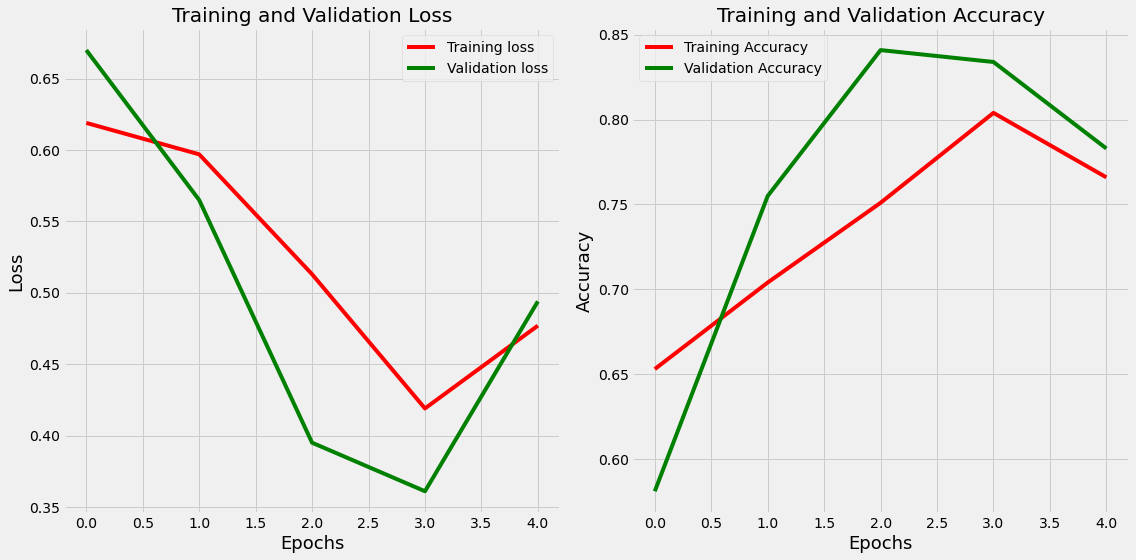

there were 177 errors in 723 tests for an accuracy of  75.52%
The F1-score was 75.103


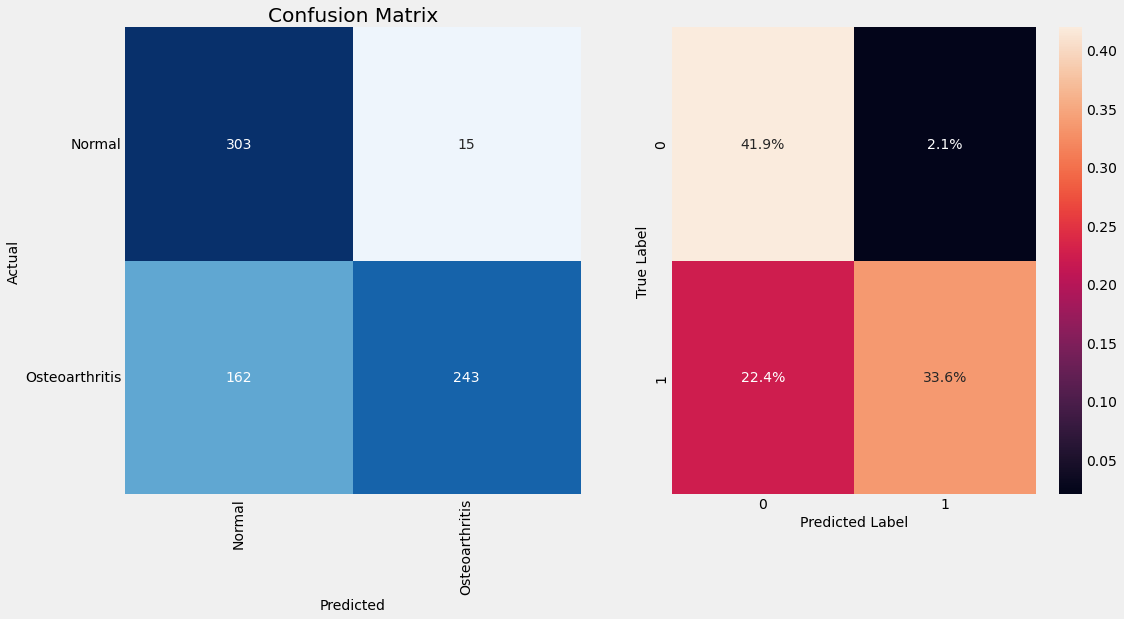

Classification Report:
----------------------
                 precision    recall  f1-score   support

        Normal     0.6516    0.9528    0.7739       318
Osteoarthritis     0.9419    0.6000    0.7330       405

      accuracy                         0.7552       723
     macro avg     0.7967    0.7764    0.7535       723
  weighted avg     0.8142    0.7552    0.7510       723

score_array: (723, 2)
label_onehot: (723, 2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:481: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


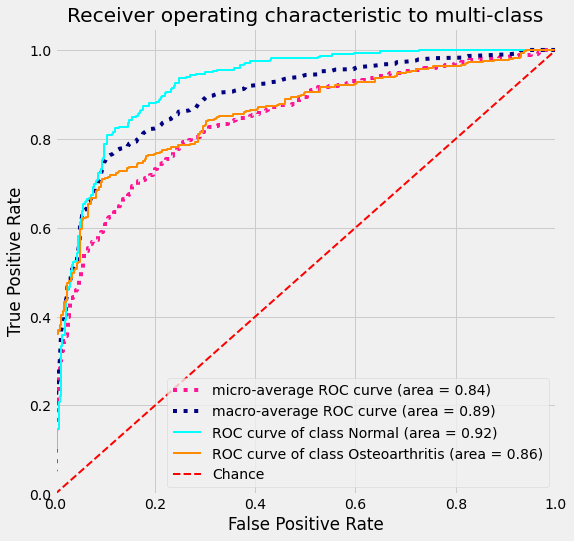

In [8]:
class NeuralNetwork():

    def __init__(self, root='tmp/', epochs=5, batch_size=32, learning_rate=0.0003, model_name=None, plot_roc=True,
                 predictor=True, plot_acc_loss=True, best_val_acc=0, save_path='./Weights', use_multi_gpus=False,
                 plot_image_class_distribution=True, save_name='./Weights/model.pth', csv_path='./ValAccuracy.csv'):

        """
        root: Your image_data path
        epochs: Training_epochs (default 5)
        batch_size: Batch_size [default 32 (if you want to change the batch_size, you also need change the learning_rate)]
        learning_rate: Optimizer learning_rate (default 0.01)
        model_name: Choose your model {'ResNet50', 'ResNet101', 'ResNet152'}(default None: if None, use 'ResNet50')
        predictor: Do you need predict and plot confusion_matrix? (default False)
        plot_acc_loss: Do you need plot train_accuracy train_loss val_accuracy val_loss? (default False)
        best_val_acc: Initial the best val accuracy for comparing with val_accuracy every epoch (default 0)
        save_path: The directory for save model weights (default './Weights')
        use_multi_gpus: Do you want to use multi_gpus? (default False)
        plot_image_class_distribution: Do you want to plot every classes distribution in a bar_plot? (default False)
        save_name: Your model_weight's name (default './Weights/model.pth')
        csv_path: Create a csv file to write accuracy and loss for every epoch (default './ValAccuracy.csv')
        """

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.plot_roc = plot_roc

        if use_multi_gpus:
            assert torch.cuda.device_count() > 1, 'You must be have more than one gpu'
            self.devices = [
                torch.device(i) for i in range(torch.cuda.device_count())
            ]

        self.model_dict = {
            'ResNet50': [3, 4, 6, 3],
            'ResNet101': [3, 4, 23, 3],
            'ResNet152': [3, 4, 36, 3]
        }

        self.plot_acc_loss = plot_acc_loss
        self.predictor = predictor
        self.lr = learning_rate
        self.use_multi_gpus = use_multi_gpus
        self.root = root
        self.epochs = epochs
        self.batch_size = batch_size
        self.plot_image_class_distribution = plot_image_class_distribution
        self.save_path = save_path
        self.save_name = save_name
        self.model_name = model_name
        self.csv_path = csv_path
        self.best_val_acc = best_val_acc

        self.data_transform = {
            'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
            'valid': transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        }

    @staticmethod
    def read_split_data(root, plot_image=False):
        filepaths = []
        labels = []
        bad_images = []

        random.seed(0)
        assert os.path.exists(root), f'Your data_path: {root} is wrong!'

        classes = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
        classes.sort()
        class_indices = {k: v for v, k in enumerate(classes)}

        json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

        with open('./classes_indices.json', 'w') as json_file:
            json_file.write(json_str)

        every_class_num = []
        supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
        for klass in classes:
            classpath = os.path.join(root, klass)
            images = [os.path.join(root, klass, i) for i in os.listdir(classpath) if
                      os.path.splitext(i)[-1] in supported]
            every_class_num.append(len(images))
            flist = sorted(os.listdir(classpath))
            desc = f'{klass:23s}'
            for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
                fpath = os.path.join(classpath, f)
                fl = f.lower()
                index = fl.rfind('.')
                ext = fl[index:]
                if ext in supported:
                    try:
                        img = cv2.imread(fpath)
                        filepaths.append(fpath)
                        labels.append(klass)
                    except:
                        bad_images.append(fpath)
                        print('defective image file: ', fpath)
                else:
                    bad_images.append(fpath)

        Fseries = pd.Series(filepaths, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        df = pd.concat([Fseries, Lseries], axis=1)

        print(f'{len(df.labels.unique())} kind of images were found in the dataset')
        train_df, test_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

        train_image_path = train_df['filepaths'].tolist()
        val_image_path = test_df['filepaths'].tolist()

        train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
        val_image_label = [class_indices[i] for i in test_df['labels'].tolist()]

        sample_df = train_df.sample(n=50, replace=False)
        ht, wt, count = 0, 0, 0
        for i in range(len(sample_df)):
            fpath = sample_df['filepaths'].iloc[i]
            try:
                img = cv2.imread(fpath)
                h = img.shape[0]
                w = img.shape[1]
                ht += h
                wt += w
                count += 1
            except:
                pass

        have = int(ht / count)
        wave = int(wt / count)
        aspect_ratio = have / wave
        print('{} images were found in the dataset.\n{} for training, {} for validation'.format(
            sum(every_class_num), len(train_image_path), len(val_image_path)
        ))
        print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

        if plot_image:
            plt.bar(range(len(classes)), every_class_num, align='center')
            plt.xticks(range(len(classes)), classes)

            for i, v in enumerate(every_class_num):
                plt.text(x=i, y=v + 5, s=str(v), ha='center')

            plt.xlabel('image class')
            plt.ylabel('number of images')

            plt.title('class distribution')
            plt.show()
        return train_image_path, train_image_label, val_image_path, val_image_label, class_indices

    def train_step(self, net, optimizer, data_loader, device, epoch):
        net.train()
        loss_function = nn.CrossEntropyLoss()
        train_acc, train_loss, sampleNum = 0, 0, 0
        optimizer.zero_grad()

        train_bar = tqdm(data_loader, file=sys.stdout, colour='red')
        for step, data in enumerate(train_bar):
            images, labels = data
            sampleNum += images.shape[0]
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs, labels)
            train_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            train_bar.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch, train_loss / (step + 1),
                                                                                 train_acc / sampleNum)
        return round(train_loss / (step + 1), 3), round(train_acc / sampleNum, 3)

    @torch.no_grad()
    def val_step(self, net, data_loader, device, epoch):
        loss_function = nn.CrossEntropyLoss()
        net.eval()
        val_acc = 0
        val_loss = 0
        sample_num = 0
        val_bar = tqdm(data_loader, file=sys.stdout, colour='red')
        for step, data in enumerate(val_bar):
            images, labels = data
            sample_num += images.shape[0]
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, dim=1) == labels).sum().item()
            val_bar.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch, val_loss / (step + 1),
                                                                               val_acc / sample_num)
        return round(val_loss / (step + 1), 3), round(val_acc / sample_num, 3)

    def fit(self):
        train_image_path, train_image_label, val_image_path, val_image_label, class_indices = self.read_split_data(
            self.root, self.plot_image_class_distribution)

        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        if os.path.exists(self.csv_path):
            self.best_val_acc = max(pd.read_csv(self.csv_path)['Val_Accuracy'].tolist())
            df = pd.DataFrame(index=list(range(self.epochs)),
                              columns=['Epochs', 'Train_Loss', 'Train_Accuracy', 'Val_Loss', 'Val_Accuracy'])
        else:
            df = pd.DataFrame(index=list(range(self.epochs)),
                              columns=['Epochs', 'Train_Loss', 'Train_Accuracy', 'Val_Loss', 'Val_Accuracy'])

        # ResMLP Block
        class ResidualMLPBlock(nn.Module):
            def __init__(self, input_units, output_units, residual_path) -> None:
                super().__init__()

                self.residual_path = residual_path

                self.features_1 = nn.Sequential(
                    nn.Linear(input_units, output_units), nn.ReLU(),
                    nn.Linear(output_units, output_units), nn.ReLU()
                )

                if residual_path:
                    self.features_2 = nn.Sequential(
                        nn.Linear(input_units, output_units), nn.GELU(),
                        nn.Linear(output_units, output_units), nn.GELU()
                    )

            def forward(self, x):
                residual = x
                y = self.features_1(x)
                if self.residual_path:
                    residual = self.features_2(x)
                output = y + residual
                return output

        # 残差MLP 特征融合 鲁棒性更好 相对于简单MLP来说不易过拟合
        class ResMLP(nn.Module):
            def __init__(self, initial_units, block_list, num_classes, initial_weights=True) -> None:
                super().__init__()

                self.initial_units = initial_units
                self.block_list = block_list

                self.layer1 = nn.Sequential(
                    nn.Linear(initial_units, 32),
                    nn.BatchNorm1d(num_features=32),
                    nn.ReLU(inplace=True)
                )

                self.layer2 = self._make_layer(block_num=self.block_list[0], input_units=32, output_units=64)
                self.layer3 = self._make_layer(block_num=self.block_list[1], input_units=64, output_units=128)
                self.layer4 = self._make_layer(block_num=self.block_list[2], input_units=128, output_units=256)
                self.layer5 = self._make_layer(block_num=self.block_list[3], input_units=256, output_units=512)

                self.out = nn.Sequential(
                    nn.Dropout(0.5),
                    nn.Linear(512, num_classes)
                )

                if initial_weights:
                    self._initialize_weights()

            def _make_layer(self, block_num, input_units, output_units):
                blocks = []
                blocks.append(ResidualMLPBlock(input_units, output_units, residual_path=True))
                for _ in range(1, block_num):
                    blocks.append(ResidualMLPBlock(output_units, output_units, residual_path=False))

                return nn.Sequential(*blocks)

            def _initialize_weights(self):
                for m in self.modules():
                    if isinstance(m, nn.Linear):
                        nn.init.normal_(m.weight, 0, 0.01)
                        nn.init.constant_(m.bias, 0)

            def forward(self, x):
                x = self.layer1(x)
                x = self.layer2(x)
                x = self.layer3(x)
                x = self.layer4(x)
                x = self.layer5(x)
                y = self.out(x)
                return y

        # ResNet50+ResMLP 引入30层残差MLP 一共80层网络 泛化性比Res50要好 F1-score分数更高 不易过拟合 可根据实际情况使用
        class ResNet(nn.Module):
            def __init__(self, num_classes) -> None:
                super().__init__()

                self.features = torchvision.models.resnet50(pretrained=True)
                self.classifier = ResMLP(initial_units=1000, block_list=[2, 2, 2, 2], num_classes=num_classes)

                for m in self.modules():
                    if isinstance(m, nn.Linear):
                        nn.init.xavier_normal_(m.weight)
                        nn.init.constant_(m.bias, 0)

            def forward(self, x):
                x = self.features(x)
                y = self.classifier(x)
                return y

        class MyDataset(Dataset):
            def __init__(self, image_path, image_labels, transform=None):
                self.image_path = image_path
                self.image_class = image_labels
                self.transform = transform

            def __len__(self):
                return len(self.image_path)

            def __getitem__(self, item):
                # 转成RGB格式
                img = Image.open(self.image_path[item]).convert('RGB')
                label = self.image_class[item]
                if self.transform is not None:
                    img = self.transform(img)
                return img, label

            # DataLoader 方法会用到 如果不设置 则使用官方默认的
            @staticmethod
            def collate_fn(batch):
                images, labels = tuple(zip(*batch))
                images = torch.stack(images, dim=0)
                labels = torch.as_tensor(labels)
                return images, labels

        train_dataset = MyDataset(train_image_path, train_image_label, self.data_transform['train'])
        valid_dataset = MyDataset(val_image_path, val_image_label, self.data_transform['valid'])

        # Linux 环境下可以开启多线程 num_workers
        system_name = sys.platform
        nw = min([os.cpu_count(), self.batch_size if self.batch_size > 1 else 0, 8]) if 'linux' in system_name else 0
        train_loader = DataLoader(train_dataset, shuffle=True, batch_size=self.batch_size, pin_memory=True,
                                  num_workers=nw, collate_fn=train_dataset.collate_fn)
        valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=self.batch_size, pin_memory=True,
                                  num_workers=nw, collate_fn=valid_dataset.collate_fn)

        if self.model_name:
            net = ResNet(num_classes=2)
        else:
            self.model_name = 'ResNet50'
            net = ResNet(num_classes=2)

        if self.use_multi_gpus:
            net = nn.DataParallel(net, device_ids=self.devices).to(self.devices[0])
        else:
            net = net.to(self.device)

        # summary(net, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size",
        #             "num_params", "kernel_size", "mult_adds", "trainable"])

        optimizer = torch.optim.Adam(net.parameters(), lr=self.lr)
        train_Loss, train_Accuracy, val_Loss, val_Accuracy = [], [], [], []

        tb_writer = SummaryWriter()
        scheduler = CosineAnnealingLR(optimizer, T_max=1)
        for epoch in range(self.epochs):
            train_loss, train_accuracy = self.train_step(net, optimizer, train_loader,
                                                         self.devices[0] if self.use_multi_gpus else self.device, epoch)
            val_loss, val_accuracy = self.val_step(net, valid_loader,
                                                   self.devices[0] if self.use_multi_gpus else self.device, epoch)
            scheduler.step()

            train_Loss.append(train_loss)
            train_Accuracy.append(train_accuracy)
            val_Loss.append(val_loss)
            val_Accuracy.append(val_accuracy)

            # Tensorboard Plot
            tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]

            tb_writer.add_scalar(tags[0], train_loss, epoch)
            tb_writer.add_scalar(tags[1], train_accuracy, epoch)
            tb_writer.add_scalar(tags[2], val_loss, epoch)
            tb_writer.add_scalar(tags[3], val_accuracy, epoch)
            tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

            if val_accuracy > self.best_val_acc:
                self.best_val_acc = val_accuracy
                torch.save(net.state_dict(), self.save_name)

        # 'Train_Loss', 'Train_Accuracy', 'Val_Loss', 'Val_Accuracy'
        df['Epochs'] = list(range(self.epochs))
        df['Train_Loss'] = train_Loss
        df['Train_Accuracy'] = train_Accuracy
        df['Val_Loss'] = val_Loss
        df['Val_Accuracy'] = val_Accuracy

        df.to_csv(self.csv_path, index=False)

        if self.plot_acc_loss:
            self.Plot_Acc_Loss(df)

        if self.predictor:
            self.Predictor(net, valid_loader)

        if self.plot_roc:
            self.Plot_ROC(net, valid_loader)


    def Plot_ROC(self, net, val_loader):

        try:
            json_file = open('./classes_indices.json', 'r')
            class_indict = json.load(json_file)
        except Exception as e:
            print(e)
            exit(-1)

        score_list = []  # 存储预测得分
        label_list = []  # 存储真实标签

        net.load_state_dict(torch.load(self.save_name))

        for i, data in enumerate(val_loader):
            images, labels = data
            images, labels = images.to(self.device), labels.to(self.device)
            outputs = torch.softmax(net(images), dim=0)
            score_tmp = outputs
            score_list.extend(score_tmp.detach().cpu().numpy())
            label_list.extend(labels.cpu().numpy())

        score_array = np.array(score_list)
        # 将label转换成onehot形式
        label_tensor = torch.tensor(label_list)
        label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
        label_onehot = torch.zeros(label_tensor.shape[0], len(class_indict.keys()))
        label_onehot.scatter_(dim=1, index=label_tensor, value=1)
        label_onehot = np.array(label_onehot)

        print("score_array:", score_array.shape)  # (batchsize, classnum)
        print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

        # 调用sklearn库，计算每个类别对应的fpr和tpr
        fpr_dict = dict()
        tpr_dict = dict()
        roc_auc_dict = dict()
        for i in range(len(class_indict.keys())):
            fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
            roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
        # micro
        fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
        roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

        # macro
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(class_indict.keys()))]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(len(set(label_list))):
            mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])

        # Finally average it and compute AUC
        mean_tpr /= len(class_indict.keys())
        fpr_dict["macro"] = all_fpr
        tpr_dict["macro"] = mean_tpr
        roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

        # 绘制所有类别平均的roc曲线
        plt.figure(figsize=(8, 8))
        lw = 2
        plt.plot(fpr_dict["micro"], tpr_dict["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc_dict["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr_dict["macro"], tpr_dict["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc_dict["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(len(class_indict.keys())), colors):
            plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                           ''.format(class_indict[str(i)], roc_auc_dict[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance', color='red')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        # plt.savefig('set113_roc.jpg')
        plt.show()


    def Plot_Acc_Loss(self, df):
        Epochs = df.loc[:, 'Epochs'].tolist()
        tloss = df.loc[:, 'Train_Loss'].tolist()
        vloss = df.loc[:, 'Val_Loss'].tolist()
        tacc = df.loc[:, 'Train_Accuracy'].tolist()
        vacc = df.loc[:, 'Val_Accuracy'].tolist()

        plt.style.use('fivethirtyeight')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
        axes[0].plot(Epochs, tloss, 'r', label='Training loss')
        axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].set_xlabel('Epochs', fontsize=18)
        axes[0].set_ylabel('Loss', fontsize=18)
        axes[0].legend()

        axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
        axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
        axes[1].set_title('Training and Validation Accuracy')
        axes[1].set_xlabel('Epochs', fontsize=18)
        axes[1].set_ylabel('Accuracy', fontsize=18)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def Predictor(self, net, test_loader):
        try:
            json_file = open('./classes_indices.json', 'r')
            class_indict = json.load(json_file)
        except Exception as e:
            print(e)
            exit(-1)

        errors = 0
        y_pred, y_true = [], []
        net.load_state_dict(torch.load(self.save_name))

        net.eval()
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                preds = torch.argmax(torch.softmax(net(images), dim=0), dim=1)
                for i in range(len(preds)):
                    y_pred.append(preds[i].cpu())
                    y_true.append(labels[i].cpu())

        tests = len(y_pred)
        for i in range(tests):
            pred_index = y_pred[i]
            true_index = y_true[i]
            if pred_index != true_index:
                errors += 1
        acc = (1 - errors / tests) * 100
        print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%')

        ypred = np.array(y_pred)
        ytrue = np.array(y_true)

        f1score = f1_score(ytrue, ypred, average='weighted') * 100

        print(f'The F1-score was {f1score:.3f}')
        class_count = len(list(class_indict.values()))
        classes = list(class_indict.values())

        cm = confusion_matrix(ytrue, ypred)
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90, fontsize=14)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0, fontsize=14)
        plt.xlabel("Predicted", fontsize=14)
        plt.ylabel("Actual", fontsize=14)
        plt.title("Confusion Matrix")

        plt.subplot(1, 2, 2)
        sns.heatmap(cm / np.sum(cm), annot=True, fmt='.1%')
        plt.xlabel('Predicted Label', fontsize=14)
        plt.xticks(fontsize=14)
        plt.ylabel('True Label', fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()

        clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
        print("Classification Report:\n----------------------\n", clr)


if __name__ == '__main__':
    model = NeuralNetwork()
    model.fit()